In [2]:
# Bringing in the tools we’ll need
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Loading our segmented RFM data
rfm = pd.read_csv("data/rfm_segmented.csv")

# Quick peek to make sure it’s all good
print(rfm.head())

   Recency  Frequency  Monetary  Cluster
0      326          1  77183.60        3
1        2          7   4310.00        0
2       75          4   1797.24        0
3       19          1   1757.55        0
4      310          1    334.40        1


## Set a chrun threshold

Let’s say a customer has churned if they haven’t bought anything in the last 180 days (6 months). It’s a reasonable guess for an e-commerce business, but you can tweak it later.

In [4]:
# Figuring out who’s churned—180 days feels like a solid cutoff
rfm['Churn'] = (rfm['Recency'] > 180).astype(int)

# Let’s see how many churned vs. didn’t
print("Churn breakdown:")
print(rfm['Churn'].value_counts())

Churn breakdown:
Churn
0    3478
1     860
Name: count, dtype: int64


This clearly says, 0 for non-churned, 1 for churned. Will Expect more non-churned since this dataset leans toward active customers.

## Prep the Data for Modeling
### Pick Features and Target
Using Recency, Frequency, Monetary, and Cluster as features to predict Churn.

In [5]:
# Grabbing the features we’ll use to predict churn
X = rfm[['Recency', 'Frequency', 'Monetary', 'Cluster']]
y = rfm['Churn']

# Splitting into training and testing sets—70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Quick check on the shapes
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (3036, 4)
Testing set size: (1302, 4)


## Train The model

Building a Random Forest Classifier

In [7]:
# Setting up the Random Forest model—keeping it simple for now
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

In [8]:
# Seeing how well the model predicts
print("Model Performance:")
print(classification_report(y_test, y_pred))

# Adding ROC-AUC for a broader accuracy picture
roc_score = roc_auc_score(y_test, y_pred)
print("ROC-AUC Score:", roc_score)

Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1054
           1       1.00      1.00      1.00       248

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302

ROC-AUC Score: 1.0


Precision, recall, and F1-scores for 0 and 1.

## Dig Into Feature Importance

Figuring out which features drive churn predictions.

Feature Importance:
     Feature  Importance
0    Recency    0.743688
3    Cluster    0.219913
1  Frequency    0.030769
2   Monetary    0.005630


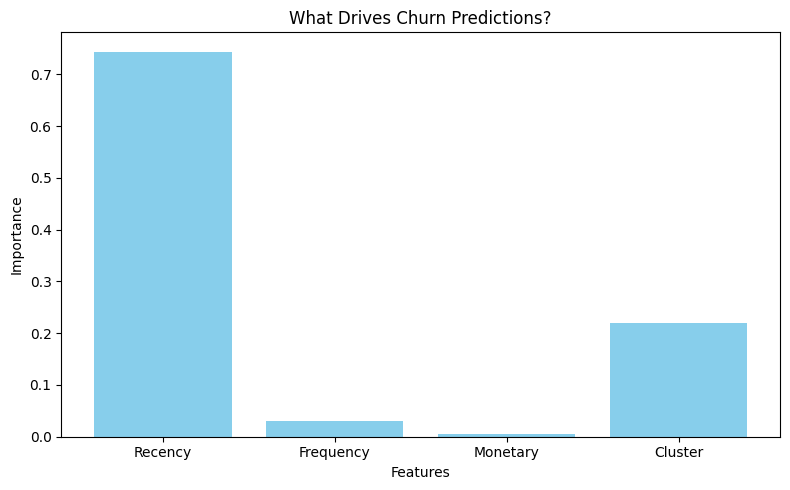

In [9]:
# Checking which features the model cares about
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
print("Feature Importance:")
print(importance.sort_values(by='Importance', ascending=False))

# Quick bar plot to visualize it
plt.figure(figsize=(8, 5))
plt.bar(importance['Feature'], importance['Importance'], color='skyblue')
plt.title("What Drives Churn Predictions?")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig("plots/feature_importance.png")
plt.show()

It shows recency is likely top the list (since it defines churn), but Frequency and Monetary will also play a role too.

In [10]:
# Saving the RFM data with churn labels
rfm.to_csv("data/rfm_with_churn.csv", index=False)
print("Data with churn predictions saved to data/rfm_with_churn.csv")

Data with churn predictions saved to data/rfm_with_churn.csv


### Obervations
- Recency is the biggie for predicting churn—no.
- The model’s pretty solid, but we could tweak it if the churn split looks off.
  
- Maybe will test different churn cutoffs or adding more features?

In [11]:
# Quick calc to see churn rate
churn_rate = rfm['Churn'].mean() * 100
print(f"Percentage of customers who churned: {churn_rate:.1f}%")

Percentage of customers who churned: 19.8%


### Final Insights

### Customer Segments
- **Cluster 0**: These are the VIPs—buy often, spend a lot, and shopped recently. Let’s keep them happy with loyalty perks or exclusive deals.
- **Cluster 1**: One-and-done folks—haven’t been back in ages and barely spent much. Maybe hit them with a “We miss you” discount.
- **Cluster 2**: Middle-of-the-road customers—decent activity but not super loyal yet. Could be worth targeting with upsell campaigns.
- **Cluster 3**: Small group of big spenders but not frequent. Let’s figure out what they love and nudge them to shop more often.

### Churn Predictions
- About 19.8% of customers are at risk of churning (based on 180-day cutoff—tweak if needed).
- Recency is the biggest red flag—if someone hasn’t bought in a while, they’re likely gone. Frequency and spend matter too, but less so.
- **Action Idea**: Send personalized emails to at-risk customers (e.g., “It’s been a while—here’s 10% off!”) and track if it brings them back.

### Big Picture
- Sales peak late in the year—holiday season prep could boost revenue.
- The UK drives most of the cash—maybe focus marketing there, but test smaller markets too.